# Data Preparation

Data Cleaning and Imputation for columns ignored in the CARES Research Paper.

### Observations & Imputation Strategies
- *Update missing values of 'DaysbetweenDeathandoperation' with a high value*
- *Cannot drop 'PreopEGFRMDRD' - Significant predictor for 30 day mortality ([Paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7936476/))*

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
from duckdb import sql

In [2]:
# Import dataset
data = pd.read_csv("../data/CARES_encoded.csv")

### Drop Duplicated columns

In [3]:
# Remove duplicated records with respect to all columns
data = data.drop_duplicates()
data.reset_index(drop=True, inplace=True)
len(data)

73201

### Check Missing Values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73201 entries, 0 to 73200
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   GENDER                             73201 non-null  int64  
 1   RCRI score                         50370 non-null  float64
 2   Anemia category                    72216 non-null  float64
 3   PreopEGFRMDRD                      70069 non-null  float64
 4   DaysbetweenDeathandoperation       5595 non-null   float64
 5   Preoptransfusionwithin30days       73201 non-null  float64
 6   Intraop                            73201 non-null  float64
 7   Postopwithin30days                 73201 non-null  float64
 8   Transfusionintraandpostop          73201 non-null  float64
 9   AnaestypeCategory                  73201 non-null  int64  
 10  PriorityCategory                   73201 non-null  int64  
 11  TransfusionIntraandpostopCategory  73201 non-null  obj

In [5]:
# Define categorical, numeric & target columns
# Define the target columns
target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'Mortality']

# Select categorical columns and exclude target columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns.to_list()
cat_cols = [col for col in cat_cols if col not in target_cols]

# Select numerical columns and exclude target columns
num_cols = data.select_dtypes(include=['number']).columns.tolist()
num_cols = [col for col in num_cols if col not in target_cols]

# Columns ignored in the research paper
rev_cols = ['RCRI score','PreopEGFRMDRD','Preoptransfusionwithin30days','Intraop','Postopwithin30days','Transfusionintraandpostop','AnaestypeCategory','TransfusionIntraandpostopCategory']

In [6]:
cat_cols

['TransfusionIntraandpostopCategory']

In [7]:
num_cols

['GENDER',
 'RCRI score',
 'Anemia category',
 'PreopEGFRMDRD',
 'DaysbetweenDeathandoperation',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Postopwithin30days',
 'Transfusionintraandpostop',
 'AnaestypeCategory',
 'PriorityCategory',
 'AGEcategory',
 'SurgRiskCategory',
 'CVARCRICategory',
 'IHDRCRICategory',
 'CHFRCRICategory',
 'DMinsulinRCRICategory',
 'CreatinineRCRICategory',
 'GradeofKidneyCategory',
 'RDW15.7',
 'ASAcategorybinned',
 'Chinese',
 'Indian',
 'Malay']

In [8]:
target_cols

['ICUAdmgt24h', 'thirtydaymortality', 'Mortality']

In [9]:
rev_cols

['RCRI score',
 'PreopEGFRMDRD',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Postopwithin30days',
 'Transfusionintraandpostop',
 'AnaestypeCategory',
 'TransfusionIntraandpostopCategory']

In [10]:
# Function to calculate the percentage of missing data for given columns
def calculate_missing_data_percentage(data, columns):
    missing_data = data[columns].isnull().mean() * 100
    return missing_data

# Calculate the percentage of missing data for reviewed columns
missing_rev_cols = calculate_missing_data_percentage(data, rev_cols)
print("\nPercentage of missing data in review columns:")
print(missing_rev_cols)



Percentage of missing data in review columns:
RCRI score                           31.189465
PreopEGFRMDRD                         4.278630
Preoptransfusionwithin30days          0.000000
Intraop                               0.000000
Postopwithin30days                    0.000000
Transfusionintraandpostop             0.000000
AnaestypeCategory                     0.000000
TransfusionIntraandpostopCategory     0.000000
dtype: float64


## 1. **RCRI score**
- ***Definition:*** *Revised Cardiac Risk Index. Six independent predictors of complications were identified and included in a Revised Cardiac Risk Index: high-risk type of surgery, history of ischemic heart disease, history of congestive heart failure, history of cerebrovascular disease, preoperative treatment with insulin, and preoperative serum creatinine >2.0 mg/dL.*
- Paper: https://pubmed.ncbi.nlm.nih.gov/10477528/
- Important predictors (based on paper): 'SurgRiskCategory', 'CVARCRICategory', 'IHDRCRICategory', 'CHFRCRICategory', 'DMinsulinRCRICategory', 'CreatinineRCRICategory', 'Age'

**FINAL IMPUTATION STRATEGY:** Impute based on ML strategy - Training RF model on important predictors & running inference on RCRI_score.

The RCRI Score is already label encoded (0, 1, 2, 3, 4, 5, 6)  
Need to check if we need to classify 3 and above as one class.

In [11]:
# Convert float values to strings and remove decimal places
data['RCRI score'] = data['RCRI score'].astype('Int64')
data['RCRI score'] = data['RCRI score'].astype(str)

<Axes: >

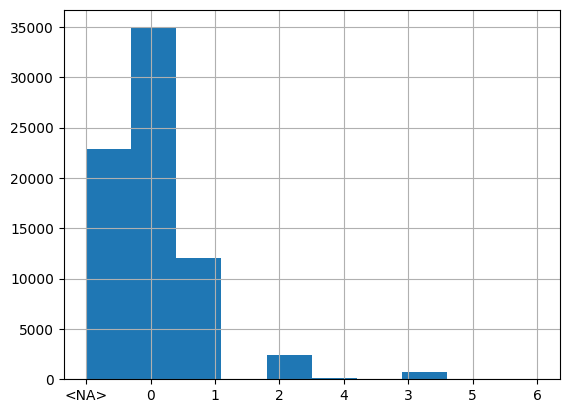

In [12]:
data['RCRI score'].hist(bins=10)

In [13]:
data['RCRI score'].value_counts()

RCRI score
0       34966
<NA>    22831
1       12087
2        2435
3         679
4         168
5          33
6           2
Name: count, dtype: int64

In [14]:
# Replace '<NA>' strings with NaN in the 'RCRI_score' column
data['RCRI score'] = data['RCRI score'].replace('<NA>', np.nan)

In [15]:
subset = data[['RCRI score', 'AGEcategory', 'SurgRiskCategory', 'CHFRCRICategory', 'CVARCRICategory', 'IHDRCRICategory', 'DMinsulinRCRICategory', 'CreatinineRCRICategory']]
subset1 = subset.loc[(~subset['RCRI score'].isnull())]
subset1.head()

,RCRI score,AGEcategory,SurgRiskCategory,CHFRCRICategory,CVARCRICategory,IHDRCRICategory,DMinsulinRCRICategory,CreatinineRCRICategory
4,0,3,0,0,0,0,0,0
8,0,2,1,0,0,0,0,0
9,1,2,1,0,0,0,0,0
10,0,2,0,0,0,0,0,0
11,1,1,1,0,0,0,0,0


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_proportions(subset1):
    '''Plot proportion of RCRI_score counts in each category normalized across RCRI_score categories'''
    
    # Define the target column
    target_col = 'RCRI score'
    
    # Get the list of other columns to plot against the target
    other_cols = [col for col in subset1.columns if col != target_col]
    
    # Set the plot style
    sns.set(style="whitegrid")
    
    # Create a proportion plot for each categorical variable
    for col in other_cols:
        # Create a cross-tabulation of the categorical column and the target column
        crosstab = pd.crosstab(subset1[col], subset1[target_col], normalize='columns')
        
        # Plot the proportions using a stacked bar plot
        crosstab.plot(kind='bar', stacked=True, figsize=(10, 6))
        
        # Set the title and labels
        plt.title(f'Proportion Plot of {col} by {target_col}')
        plt.xlabel(col)
        plt.ylabel('Proportion')
        
        # Add a legend
        plt.legend(title=target_col, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Adjust the layout and show the plot
        plt.tight_layout()
        plt.show()

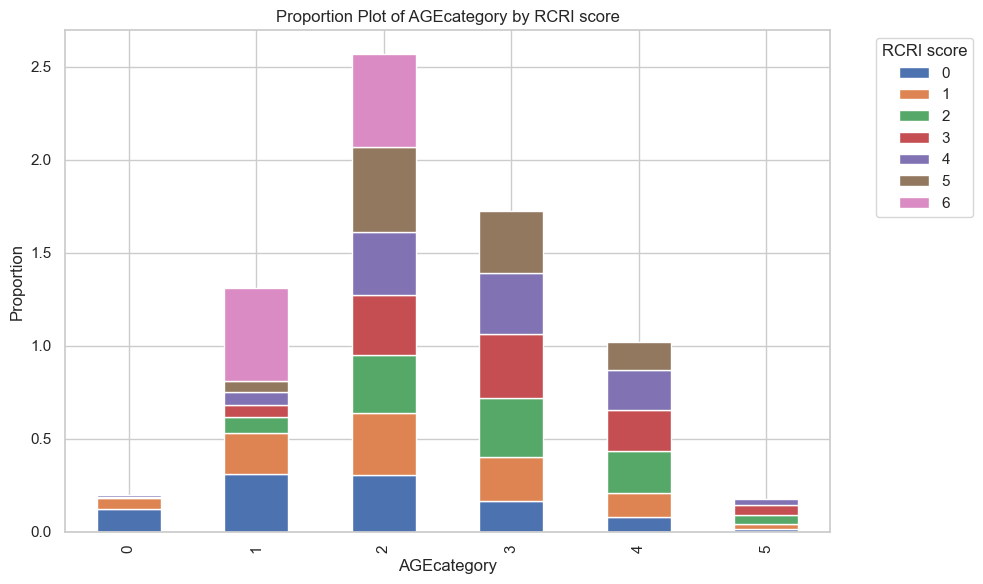

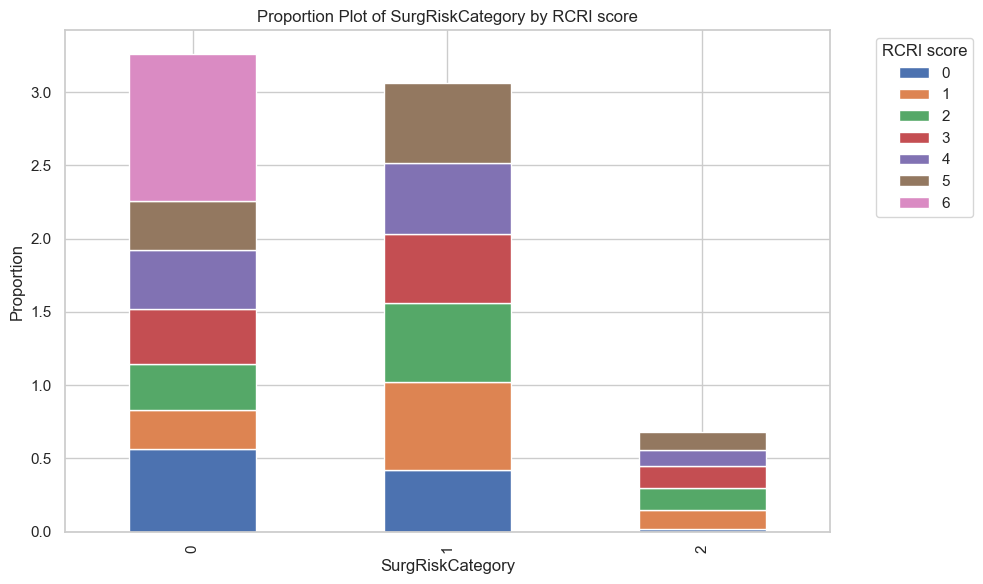

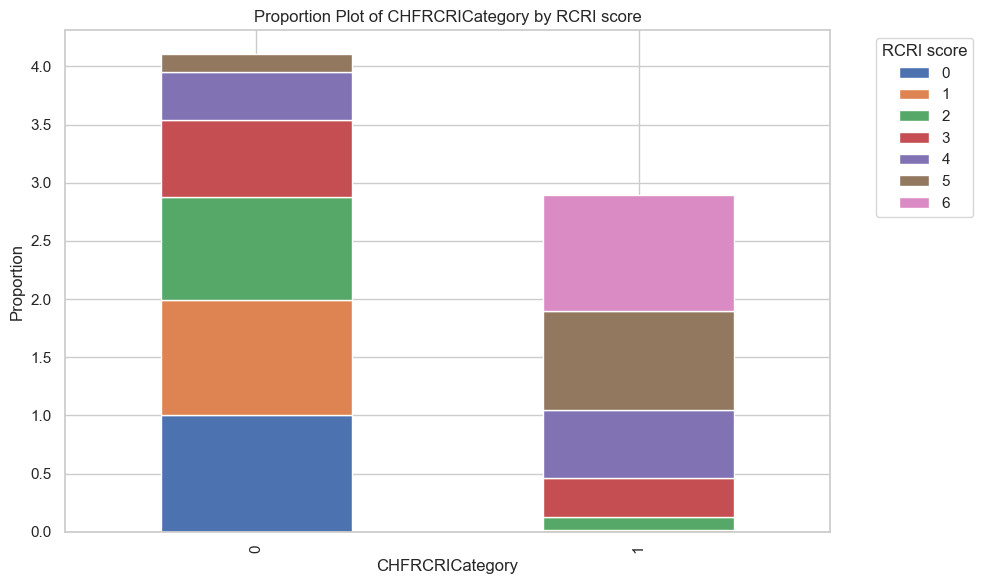

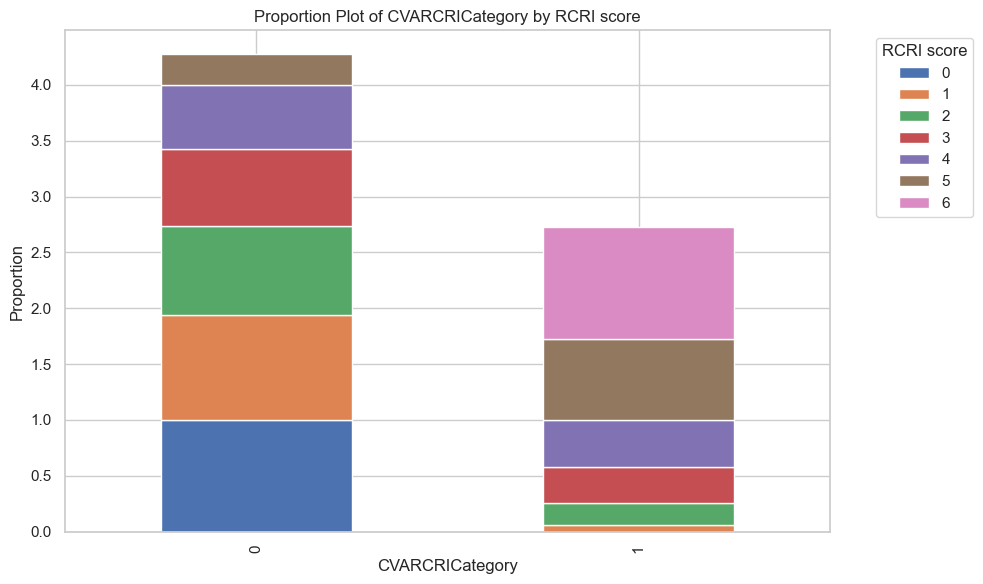

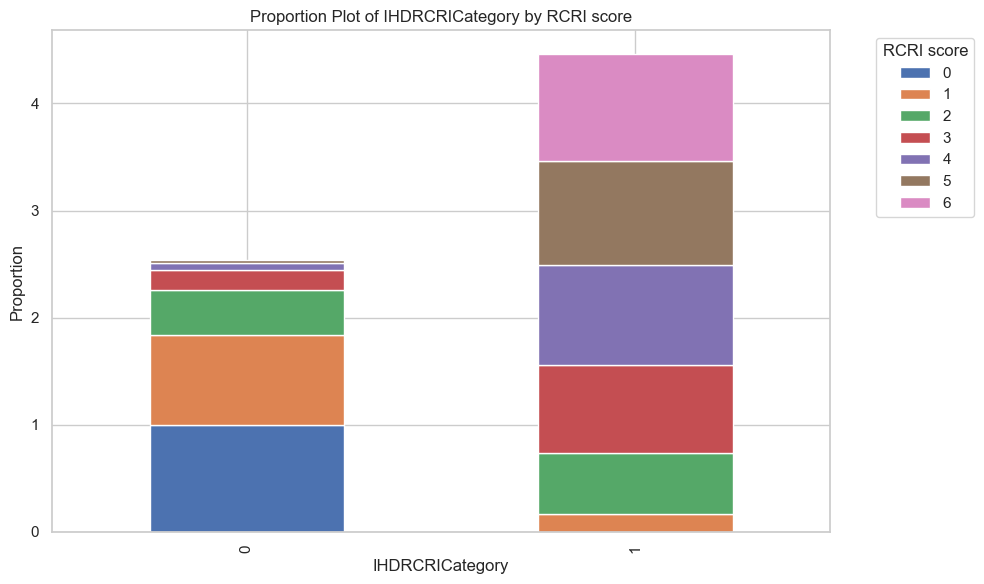

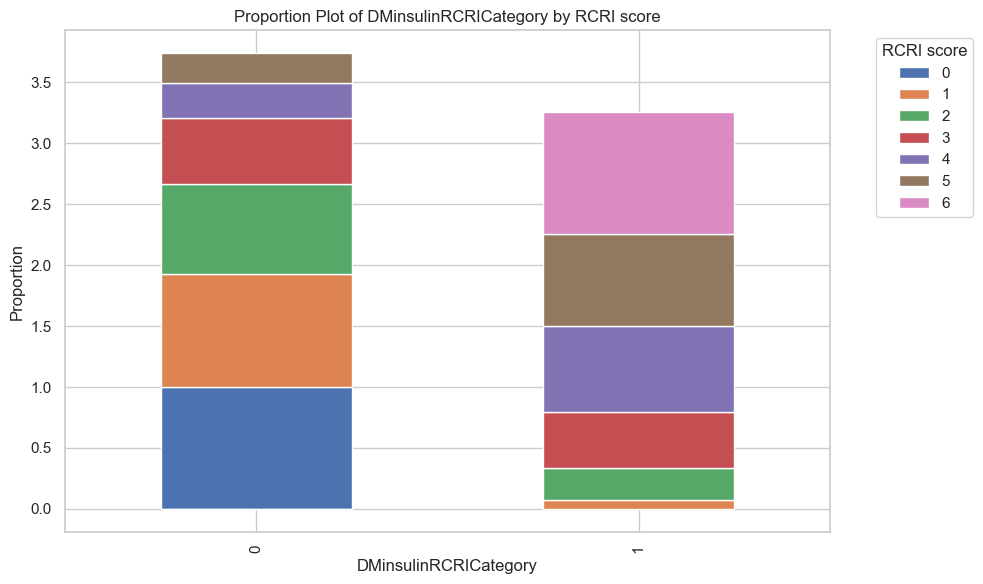

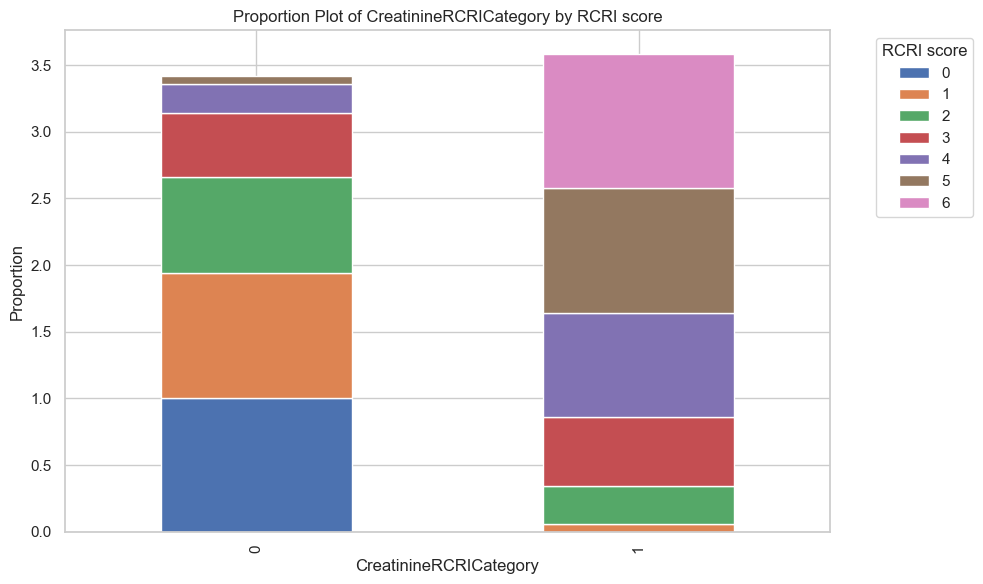

In [19]:
plot_categorical_proportions(subset1)

In [20]:
df = data.copy()

In [21]:
df['RCRI score'].isnull().sum()

np.int64(22831)

In [22]:
subset1.columns

Index(['RCRI score', 'AGEcategory', 'SurgRiskCategory', 'CHFRCRICategory',
       'CVARCRICategory', 'IHDRCRICategory', 'DMinsulinRCRICategory',
       'CreatinineRCRICategory'],
      dtype='object')

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def impute_rcri_score(subset, data):
    # Rename the column 'RCRI score' to 'RCRI_score' in both dataframes
    subset.rename(columns={'RCRI score': 'RCRI_score'}, inplace=True)
    data.rename(columns={'RCRI score': 'RCRI_score'}, inplace=True)
    
    # Define the features and target column
    features = ['AGEcategory', 'SurgRiskCategory', 'CHFRCRICategory',
       'CVARCRICategory', 'IHDRCRICategory', 'DMinsulinRCRICategory',
       'CreatinineRCRICategory']
    target_col = 'RCRI_score'
    
    # Separate features and target in subset
    X = subset[features]
    y = subset[target_col]
    
    # Define the Random Forest model with class weights
    rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the Random Forest model
    rf.fit(X_train, y_train)
    
    # Evaluate the model on the validation set
    y_val_pred = rf.predict(X_val)
    print("Validation Set Classification Report:")
    print(classification_report(y_val, y_val_pred))
    
    # Identify rows with missing 'RCRI_score' in the data
    missing_rcri_score = data[target_col].isnull()
    
    # Prepare features for rows with missing 'RCRI_score'
    X_missing = data.loc[missing_rcri_score, features]
    
    # Impute the missing values using the trained Random Forest model
    imputed_rcri_scores = rf.predict(X_missing)
    
    # Impute the missing values in the original data
    data.loc[missing_rcri_score, target_col] = imputed_rcri_scores
    
    return data

In [24]:
data = impute_rcri_score(subset1, data)

C:\Users\danie\AppData\Local\Temp\ipykernel_20424\1876182499.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.rename(columns={'RCRI score': 'RCRI_score'}, inplace=True)


Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      7015
           1       0.44      0.60      0.51      2352
           2       0.48      0.77      0.59       517
           3       0.55      0.66      0.60       146
           4       0.52      0.62      0.57        37
           5       0.38      0.43      0.40         7

    accuracy                           0.71     10074
   macro avg       0.55      0.64      0.58     10074
weighted avg       0.77      0.71      0.73     10074



In [26]:
df['RCRI score'].isnull().sum()

np.int64(22831)

In [27]:
df['RCRI score'].value_counts()

RCRI score
0    34966
1    12087
2     2435
3      679
4      168
5       33
6        2
Name: count, dtype: int64

In [28]:
data['RCRI_score'].isnull().sum()

np.int64(0)

In [29]:
data['RCRI_score'].value_counts()

RCRI_score
0    51038
1    18528
2     2735
3      695
4      170
5       33
6        2
Name: count, dtype: int64

## 2. **Preoperative Estimated Glomerular Filtration Rate using the Modification of Diet in Renal Disease (PreopEGFRMDRD)**
- **Definition:** Estimated glomerular filtration rate (eGFR), describing filtrate flow through the kidneys, is a universal surrogate indicator for assessing renal function. It has been widely used in the clinical diagnosis of chronic kidney disease (CKD).
- The PreopEGFRMDRD is typically measured in mL/min/1.73m² and is used to assess kidney function. Normal values generally range from 90 to 120 mL/min/1.73m², with lower values indicating impaired kidney function.
- Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7936476/
- **Insights:** In this study, they confirmed an independent nonlinear relationship between preop-eGFR and postoperative 30-day mortality. A stable U-shaped trend can be seen in this relationship. When preop-eGFR ≤ 98.688 mL/min/1.73 m2, the 30-day mortality would be decreased by 1.6% for each additional unit of preop-eGFR. While preop-eGFR > 98.688 mL/min/1.73 m2, there would be a 1.3% increase of 30-day mortality rate for each additional unit of preop-eGFR. CHF, DM, IHD and anemia complications (CHF, DM, IHD acting as a promoting factor, while anemia as an inhibitory factor) interfere with the effect of preop-eGFR on postoperative 30-day mortality.
- The paper excluded all cases of missing data for preop-eGFR and outliers.
- Based on the findings in the paper, we will classify the feature into two classes: preop-eGFR ≤ 98.688 mL/min/1.73 m2 and preop-eGFR > 98.688 mL/min/1.73 m2

In [31]:
data.columns

Index(['GENDER', 'RCRI_score', 'Anemia category', 'PreopEGFRMDRD',
       'DaysbetweenDeathandoperation', 'Preoptransfusionwithin30days',
       'Intraop', 'Postopwithin30days', 'Transfusionintraandpostop',
       'AnaestypeCategory', 'PriorityCategory',
       'TransfusionIntraandpostopCategory', 'AGEcategory', 'Mortality',
       'thirtydaymortality', 'SurgRiskCategory', 'CVARCRICategory',
       'IHDRCRICategory', 'CHFRCRICategory', 'DMinsulinRCRICategory',
       'CreatinineRCRICategory', 'GradeofKidneyCategory', 'RDW15.7',
       'ASAcategorybinned', 'ICUAdmgt24h', 'Chinese', 'Indian', 'Malay'],
      dtype='object')

In [34]:
data=data.dropna(subset=['PreopEGFRMDRD'])

In [41]:
threshold = 98.688

# Create a new binary feature based on the threshold
data['eGFR_Class'] = data['PreopEGFRMDRD'].apply(lambda x: 1 if x > threshold else 0)

# Print the first few rows to verify the new feature
print(data[['PreopEGFRMDRD', 'eGFR_Class']].head())

   PreopEGFRMDRD  eGFR_Class
2     152.538570           1
3     117.231496           1
4      98.651255           0
5     104.487306           1
6      72.669742           0


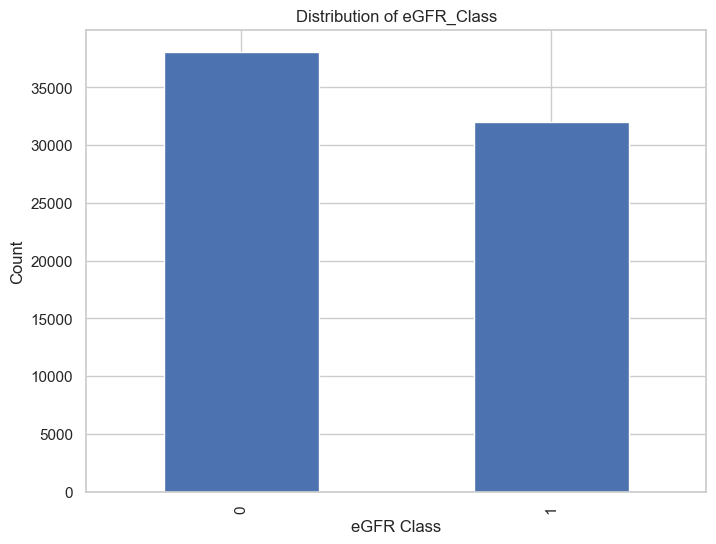

In [42]:
# Visualize the distribution of the new binary feature
plt.figure(figsize=(8, 6))
data['eGFR_Class'].value_counts().plot(kind='bar')
plt.title('Distribution of eGFR_Class')
plt.xlabel('eGFR Class')
plt.ylabel('Count')
plt.show()

In [44]:
data['PreopEGFRMDRD'] = data['eGFR_Class']
data = data.dropna(subset=['eGFR_Class'])

In [43]:
rev_cols

['RCRI score',
 'PreopEGFRMDRD',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Postopwithin30days',
 'Transfusionintraandpostop',
 'AnaestypeCategory',
 'TransfusionIntraandpostopCategory']

## **3. Pre-op transfusion (Preoptransfusionwithin30days)**
- **Definition:** Perioperative blood transfusions are often associated with an increased risk of postoperative complications, including infection, cardiovascular events, and increased mortality. This is particularly significant in patients undergoing major surgeries.
- Paper: https://pubmed.ncbi.nlm.nih.gov/15784356/
- **Insights:** The study found that patients who received peri-operative RBC transfusions had higher 30-day and 1-year mortality rates compared to those who did not receive transfusions.
- Kaplan-Meier survival curves showed a clear survival disadvantage for patients receiving RBC transfusions. This effect was observed both at 30 days and at 1 year post-surgery.

In [45]:
data['Preoptransfusionwithin30days'].value_counts()

Preoptransfusionwithin30days
0.0     68276
1.0       961
2.0       437
3.0       178
4.0        73
5.0        45
6.0        23
7.0        23
8.0        19
11.0        8
10.0        7
9.0         6
13.0        5
14.0        4
17.0        1
12.0        1
20.0        1
21.0        1
Name: count, dtype: int64

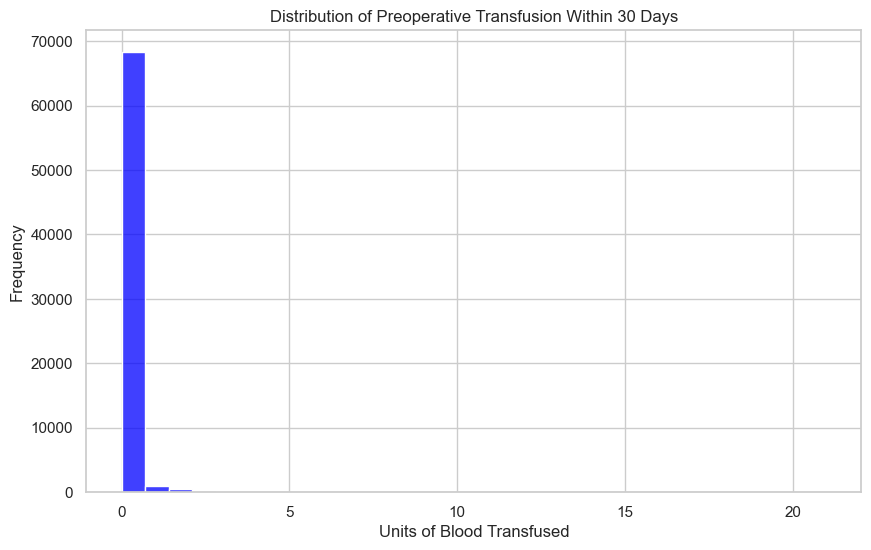

In [47]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['Preoptransfusionwithin30days'], bins=30, color='blue')
plt.title('Distribution of Preoperative Transfusion Within 30 Days')
plt.xlabel('Units of Blood Transfused')
plt.ylabel('Frequency')
plt.show()

## **4. Intra-op transfusion (Intraop)**
- **Definition:** Perioperative blood transfusions are often associated with an increased risk of postoperative complications, including infection, cardiovascular events, and increased mortality. This is particularly significant in patients undergoing major surgeries.
- Paper: https://pubmed.ncbi.nlm.nih.gov/15784356/
- **Insights:** The study found that patients who received peri-operative RBC transfusions had higher 30-day and 1-year mortality rates compared to those who did not receive transfusions.
- Kaplan-Meier survival curves showed a clear survival disadvantage for patients receiving RBC transfusions. This effect was observed both at 30 days and at 1 year post-surgery.